<a href="https://colab.research.google.com/github/BeataStultica/neural_network/blob/main/Laba6_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import cv2
import os
import sklearn.model_selection
import datetime
import zipfile
import random
from google.colab import drive

drive.mount("/content/gdrive")
zip_file = '/content/gdrive/MyDrive/detect.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

Mounted at /content/gdrive


In [2]:
from sklearn.model_selection import train_test_split
import random
images = []
labels = []
for image_name in os.listdir("/content/DataSet/Transportation/Mercedes-Benz/"):
  img = tf.keras.utils.load_img(f"/content/DataSet/Transportation/Mercedes-Benz/"+image_name, target_size=(224, 224))
  img = tf.keras.utils.img_to_array(img)
  images.append(img)
  labels.append(1)
all_img = z.namelist()
random.shuffle(all_img)
c = 0
for i in all_img:
  if 'Mercedes-Benz' in i:
    continue
  img = tf.keras.utils.load_img(f"/content/"+i, target_size=(224, 224))
  img = tf.keras.utils.img_to_array(img)
  images.append(img)
  labels.append(0)
  c +=1
  if c == 100:
    break

images = np.array(images)
labels = np.array(labels)
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 4)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (160, 224, 224, 3)
y_train shape =  (160,)

x_test shape =  (40, 224, 224, 3)
y_test shape =  (40,)


In [3]:
def block(layer,filters,kernel_size,strides=1,padding='valid',layer_name='conv',
          pool_size=2,pool_strides=None,filter_2=False):
          
  if layer_name == 'conv':
    layer = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,
                                   strides=strides,use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    layer = tf.keras.layers.Conv2D(filters=filters*2,kernel_size=kernel_size,
                                  use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
  
  elif layer_name == 'separable_conv':
    layer = tf.keras.layers.SeparableConv2D(filters, kernel_size,
                                            padding=padding, use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)    
    if filter_2:
      layer = tf.keras.layers.SeparableConv2D(filter_2, kernel_size,
                                              padding=padding, use_bias=False)(layer)
    else:
      layer = tf.keras.layers.SeparableConv2D(filters, kernel_size,
                                              padding=padding, use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.MaxPooling2D(pool_size, strides=pool_strides,
                                         padding=padding)(layer)
  return layer

def add_block(layer,filters,kernel_size,strides=1,padding='valid',pool_size=2,pool_strides=None):
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.SeparableConv2D(filters,kernel_size,padding=padding,use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.SeparableConv2D(filters,kernel_size,padding=padding,use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.MaxPooling2D(pool_size, strides=pool_strides,
                                         padding=padding)(layer)
  return layer  
def entry_flow(input_layer):	
  block_1 = block(input_layer,32,3,2,layer_name='conv')

  block_2 = block(block_1,128,3,padding='same',layer_name='separable_conv')
  layer_add = tf.keras.layers.Conv2D(filters=128,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(block_1)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)
  layer = tf.keras.layers.Add()([block_2,layer_add])

  block_3 = add_block(layer,256,3,1,'same',3,2)
  layer_add = tf.keras.layers.Conv2D(filters=256,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(layer)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)
  layer = tf.keras.layers.Add()([block_3,layer_add])

  block_4 = add_block(layer,728,3,1,'same',3,2)
  layer_add = tf.keras.layers.Conv2D(filters=728,kernel_size=1,strides=2,
                                 padding='same',use_bias=False)(layer)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)
  layer = tf.keras.layers.Add()([block_4,layer_add])
  return layer
def middle_flow(input_layer):
    for _ in range(8):
      for __ in range(3):
        layer = tf.keras.layers.ReLU()(input_layer)
        layer = tf.keras.layers.SeparableConv2D(filters=728, kernel_size=3,
                                                padding='same',use_bias=False)(layer)
        layer = tf.keras.layers.BatchNormalization()(layer)
      output_layer = tf.keras.layers.Add()([input_layer, layer])
    return output_layer
def exit_flow(input_layer):
  layer = tf.keras.layers.ReLU()(input_layer)
  block_1 = block(layer,728,3,padding='same',layer_name='separable_conv',
                  pool_size=3,pool_strides=2,filter_2=1024)
 
  layer_add = tf.keras.layers.Conv2D(filters=1024, kernel_size=1, 
                                 strides=2, padding='same', use_bias=False)(input_layer)
  layer_add = tf.keras.layers.BatchNormalization()(layer_add)                                  
  layer = tf.keras.layers.Add()([block_1, layer_add])

  layer = tf.keras.layers.SeparableConv2D(filters=1536, kernel_size=3,
                                          padding='same',use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.SeparableConv2D(filters=2048, kernel_size=3,
                                          padding='same',use_bias=False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.GlobalAvgPool2D()(layer)
  layer = tf.keras.layers.Dense(1000, activation='relu')(layer)
 
  return layer
def xception(shape,include_top):
  model_input = tf.keras.layers.Input(shape=shape)
  entry_block = entry_flow(model_input)
  mid_block = middle_flow(entry_block)
  exit_block = exit_flow(mid_block)

  if include_top:
    model_output = tf.keras.layers.Dense(1, activation='sigmoid')(exit_block)
    model = tf.keras.models.Model(model_input, model_output)
  model = tf.keras.models.Model(model_input, model_output)
  model.summary()
  return model

shape =  (224,224,3)
model = xception(shape,include_top=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [4]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
model.fit(x_train, y_train, epochs=20, batch_size=16)

Epoch 1/20
10/10 [==============================] - 2s 198ms/step - loss: 0.0179 - accuracy: 0.9937
Epoch 2/20
10/10 [==============================] - 2s 200ms/step - loss: 0.0189 - accuracy: 0.9875
Epoch 3/20
10/10 [==============================] - 2s 197ms/step - loss: 0.0155 - accuracy: 1.0000
Epoch 4/20
10/10 [==============================] - 2s 199ms/step - loss: 0.0198 - accuracy: 0.9937
Epoch 5/20
10/10 [==============================] - 2s 199ms/step - loss: 0.0642 - accuracy: 0.9812
Epoch 6/20
10/10 [==============================] - 2s 198ms/step - loss: 0.0232 - accuracy: 0.9875
Epoch 7/20
10/10 [==============================] - 2s 199ms/step - loss: 0.0131 - accuracy: 0.9937
Epoch 8/20
10/10 [==============================] - 2s 204ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 9/20
10/10 [==============================] - 2s 203ms/step - loss: 0.0085 - accuracy: 0.9937
Epoch 10/20
10/10 [==============================] - 2s 203ms/step - loss: 0.0501 - accuracy: 0.9688

In [10]:
test_loss, test_acc = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 32ms/step - loss: 1.0456 - accuracy: 0.7750


In [11]:
import imutils
def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	# yield the original image
	yield image
	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

In [18]:
from tensorflow.keras.utils import img_to_array
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = (200, 150)
INPUT_SIZE = (224, 224)
orig = cv2.imread('/content/mets.jpg')
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

rois = []
locs = []
for image in pyramid:
	# determine the scale factor between the *original* image
	# dimensions and the *current* layer of the pyramid
	scale = W / float(image.shape[1])
	# for each layer of the image pyramid, loop over the sliding
	# window locations
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		x = int(x * scale)
		y = int(y * scale)
		w = int(ROI_SIZE[0] * scale)
		h = int(ROI_SIZE[1] * scale)
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = roi.reshape((1,224,224,3))
		#roi = img_to_array(roi)
		roi = roi.astype('float32')/255
		# update our list of ROIs and associated coordinates
		rois.append(roi)
		locs.append((x, y, x + w, y + h))

In [22]:
print(len(rois))
res = []
for i in range(len(rois)):
  a = model.predict(rois[i])
  #print(a)
  if a[0] > 0.7:
    print(locs[i])
    res.append([locs[i],a[0]])

1296
(48, 320, 248, 470)
(112, 320, 312, 470)
(0, 336, 200, 486)
(16, 336, 216, 486)
(48, 336, 248, 486)
(64, 336, 264, 486)
(80, 336, 280, 486)
(112, 336, 312, 486)
(144, 336, 344, 486)
(160, 336, 360, 486)
(176, 336, 376, 486)
(208, 336, 408, 486)
(240, 336, 440, 486)
(0, 352, 200, 502)
(16, 352, 216, 502)
(48, 352, 248, 502)
(112, 352, 312, 502)
(176, 352, 376, 502)
(208, 352, 408, 502)
(240, 352, 440, 502)
(48, 368, 248, 518)
(112, 368, 312, 518)
(176, 368, 376, 518)
(48, 384, 248, 534)
(112, 384, 312, 534)
(176, 384, 376, 534)
(208, 384, 408, 534)
(240, 384, 440, 534)
(48, 400, 248, 550)
(112, 400, 312, 550)
(176, 400, 376, 550)
(112, 416, 312, 566)
(176, 416, 376, 566)
(176, 432, 376, 582)
(0, 360, 300, 585)


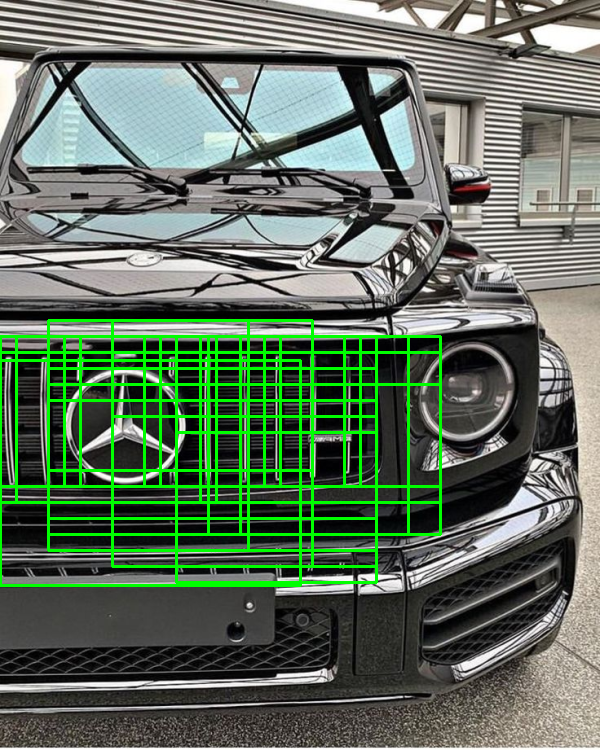

/usr/local/lib/python3.7/dist-packages/imutils/object_detection.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return boxes[pick].astype("int")


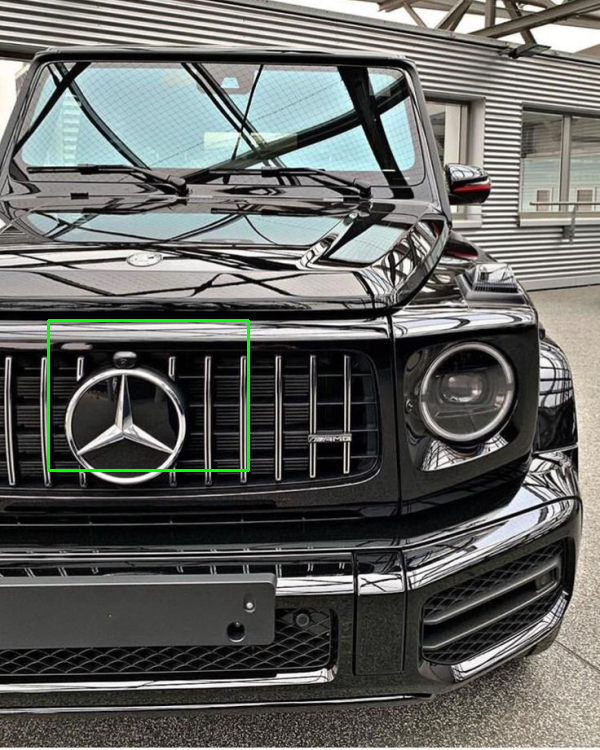

In [26]:
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
for label in range(1):
	# clone the original image so that we can draw on it
	#print("[INFO] showing results for '{}'".format(label))
	clone = orig.copy()
	# loop over all bounding boxes for the current label
	for (box, prob) in res:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
	boxes = np.array([p[0] for p in res])
	proba = np.array([p[1] for p in res])
	# applying non-maxima suppression
	cv2_imshow( clone)
	clone = orig.copy()
	boxes = non_max_suppression(boxes, proba)
	# loop over all bounding boxes that were kept after applying
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		#cv2.putText(clone, label, (startX, y),
		#	cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
	# show the output after apply non-maxima suppression
	cv2_imshow( clone)
	#cv2.waitKey(0)

In [27]:
from tensorflow.keras.utils import img_to_array
def processImage(frame):
    WIDTH = 600
    PYR_SCALE = 1.5
    WIN_STEP = 16
    ROI_SIZE = (200, 150)
    INPUT_SIZE = (224, 224)
    orig = frame
    orig = imutils.resize(orig, width=WIDTH)
    (H, W) = orig.shape[:2]
    pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

    rois = []
    locs = []
    for image in pyramid:
      # determine the scale factor between the *original* image
      # dimensions and the *current* layer of the pyramid
      scale = W / float(image.shape[1])
      # for each layer of the image pyramid, loop over the sliding
      # window locations
      for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = roi.reshape((1,224,224,3))
        #roi = img_to_array(roi)
        roi = roi.astype('float32')/255
        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))
    #print(len(rois))
    res = []
    for i in range(len(rois)):
      a = model.predict(rois[i])
      #print(a)
      if a[0] > 0.7:
        #print(locs[i])
        res.append([locs[i],a[0]])
    for label in range(1):
	# clone the original image so that we can draw on it
	#print("[INFO] showing results for '{}'".format(label))
      clone = orig.copy()
      # loop over all bounding boxes for the current label
      for (box, prob) in res:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),
          (0, 255, 0), 2)
      boxes = np.array([p[0] for p in res])
      proba = np.array([p[1] for p in res])
      # applying non-maxima suppression
      #cv2_imshow( clone)
      clone = orig.copy()
      boxes = non_max_suppression(boxes, proba)
      # loop over all bounding boxes that were kept after applying
      for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),
          (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        #cv2.putText(clone, label, (startX, y),
        #	cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
      # show the output after apply non-maxima suppression
      #cv2_imshow( clone)
      return len(res), clone

In [28]:
video_capture = cv2.VideoCapture('/content/mersedes.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
file_size = (852,480)
output_filename='/content/output.mp4'
result = cv2.VideoWriter(output_filename, fourcc, 30.0, file_size)
frame_count = 0
while (video_capture.isOpened()):
    frame_count+=1
    ret, frame = video_capture.read()
    if ret:
        ismers, output = processImage(frame)
        #cv2.putText(output, 'Dmytro Ukrainets', (980, 700), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2, cv2.LINE_4)
        #cv2.imshow('frame', output)
        result.write(output)
        if ismers>0:
          print(frame_count)
          print(frame_count/30)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
print(frame_count)
video_capture.release()
result.release()

0
